## Apodization in z

This notebooks performs apodization to taper data near axial edges

In [21]:
import os
import mrc as Mrc
import napari
from tnia.plotting.projections import show_xy_zy_slice
import numpy as np
import sys

sys.path.insert(1, r'../../python')
from simreconpython.dims_helper import reshape_zdpyx_dpzyx

In [19]:
input_path = r'D:\Janelia\Data 2024-06-30-Aug'
base_name = r'cell5crop'
input_name = os.path.join(input_path, base_name+'.mrc.')

mrc = Mrc.Mrc(input_name)
raw = mrc.data

sxy, sxy, sz = mrc.header.d[0], mrc.header.d[1], mrc.header.d[2]

print(raw.shape)
print(sxy, sz)

nx = raw.shape[2]
ny = raw.shape[1]

dkx = 1/(nx*sxy)
dky = 1/(ny*sxy)
print('dkx, dky',dkx, dky)

(240, 494, 524)
0.13 0.25
dkx, dky 0.01467997705049593 0.015571473632509852


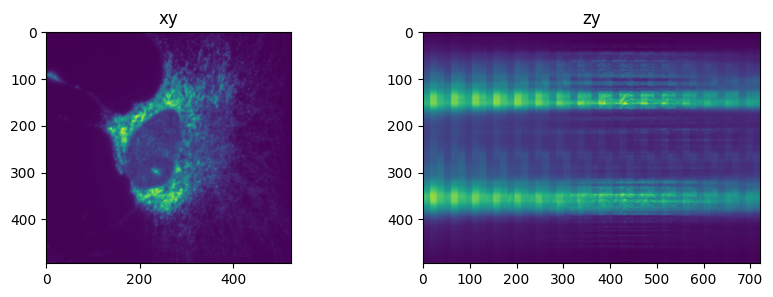

In [20]:
fig = show_xy_zy_slice(raw, x = raw.shape[2]//2, y = raw.shape[1]//2, z = 128, sxy=1, sz=3)

## Reshape

Reshape from z, dir, phase, y, x to dir, phase, z, y, x.

This is done so each volume is contiguous 

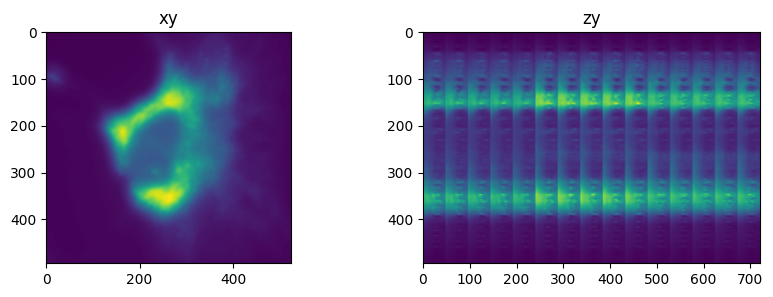

In [26]:
nphases = 5
ndirections = 3
nz = raw.shape[0]//(nphases*ndirections)
images = reshape_zdpyx_dpzyx(raw, nphases=5, ndirections=3)

# plot reshaped images
temp = images.reshape(240, images.shape[3], images.shape[4])
fig = show_xy_zy_slice(temp, x = temp.shape[2]//2, y = temp.shape[1]//2, z = 128, sxy=1, sz=3)

## Loop through each z volume and apply apodization

In [28]:
apo = images.copy().astype(np.uint16)

for d in range(ndirections):
    for p in range(nphases):
        apo[d,p,:,:] = apodize_z(apo[d,p,:,:], 3)


c:\Users\bnort\work\Janelia\code\simrecon\notebooks\processing\../../python\simreconpython\separate.py:53: RuntimeWarning: overflow encountered in scalar subtract
  diff = (image[nz-1, l, k] - image[0, l, k])/2


## Visualize original and apodized

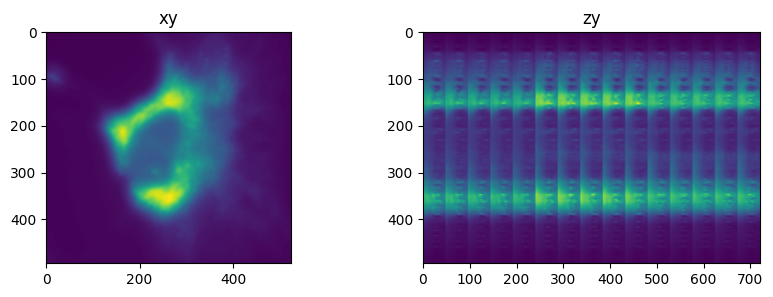

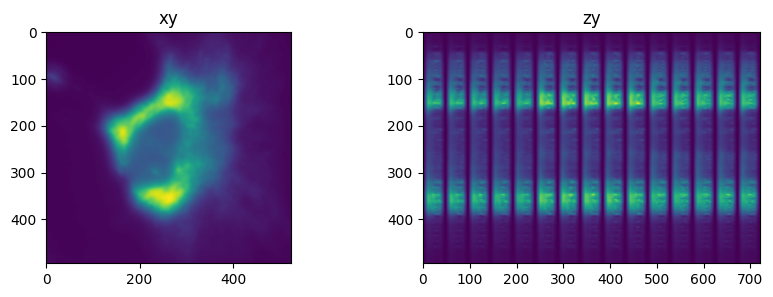

In [29]:
fig = show_xy_zy_slice(temp, x = temp.shape[2]//2, y = temp.shape[1]//2, z = 128, sxy=1, sz=3)
temp2 = apo.reshape(240, apo.shape[3], apo.shape[4])
fig = show_xy_zy_slice(temp2, x = temp.shape[2]//2, y = temp.shape[1]//2, z = 128, sxy=1, sz=3)

## View apodized and original in Napari

In [33]:
import napari
viewer = napari.Viewer()
viewer.add_image(images, name='Original Images')
viewer.add_image(apo, name='Apodized Images')

<Image layer 'Apodized Images' at 0x14a44576b70>

## Reshape back to zdpyx

In [34]:
i = 0
nz = apo.shape[2]
reshaped = np.zeros((ndirections*nphases*nz, raw.shape[1], raw.shape[2])).astype(np.uint16)
for z in range(nz):
    for d in range(ndirections):
        for p in range(nphases):
            reshaped[i,:,:] = apo[d,p,z,:,:].astype(np.uint16)
            i += 1


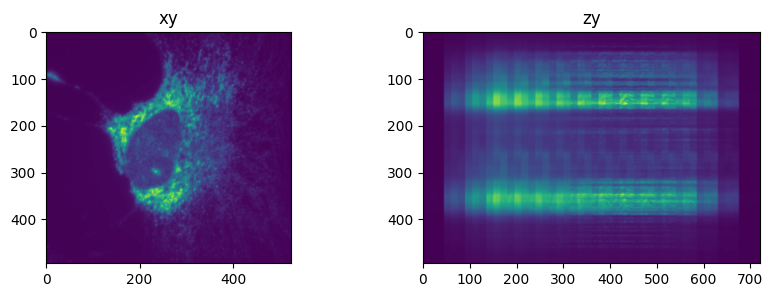

In [35]:
fig = show_xy_zy_slice(reshaped, x = temp.shape[2]//2, y = temp.shape[1]//2, z = 128, sxy=1, sz=3)

## Save apodized MRC

In [47]:
reshaped = reshaped.astype(np.uint16)
reshaped = np.clip(reshaped, 200, 65535)
output_name = os.path.join(input_path, base_name+'_apo.mrc')
Mrc.save(reshaped, output_name, hdr=mrc.hdr, ifExists='overwrite')

In [40]:
viewer = napari.Viewer()
viewer.add_image(reshaped, name='Reshaped Images')

<Image layer 'Reshaped Images' at 0x1b8981b4bf0>